# Baseline Experiment: Full-Face 

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
from collections import Counter

train_dir = 'Patient-Specific_Training_of_Deep_Learning_Models_for_Drowsiness_Detection/Datasets/DD1_Dataset/train'
train_csv = 'Patient-Specific_Training_of_Deep_Learning_Models_for_Drowsiness_Detection/Datasets/DD1_Dataset/train/_classes.csv'
val_dir = 'Patient-Specific_Training_of_Deep_Learning_Models_for_Drowsiness_Detection/Datasets/DD1_Dataset/valid'
val_csv = 'Patient-Specific_Training_of_Deep_Learning_Models_for_Drowsiness_Detection/Datasets/DD1_Dataset/valid/_classes.csv'
test_dir = 'Patient-Specific_Training_of_Deep_Learning_Models_for_Drowsiness_Detection/Datasets/DD1_Dataset/test1'
test_csv = 'Patient-Specific_Training_of_Deep_Learning_Models_for_Drowsiness_Detection/Datasets/DD1_Dataset/test1/_classes.csv'
new_test_dir = 'Patient-Specific_Training_of_Deep_Learning_Models_for_Drowsiness_Detection/Datasets/DD1_Dataset/testinginnewdataset'
new_test_csv = 'Patient-Specific_Training_of_Deep_Learning_Models_for_Drowsiness_Detection/Datasets/DD1_Dataset/testinginnewdataset/_classes.csv'


img_size = (224, 224) 
def load_and_preprocess_data(data_dir, csv_path, img_size):
    """
    Load, resize, rescale images, and calculate class distribution from a directory and a CSV file.

    Args:
        data_dir (str): Path to the directory containing images.
        csv_path (str): Path to the CSV file containing filenames and labels.
        img_size (tuple): Target size for resizing images (width, height).

    Returns:
        data (np.array): Array of resized and rescaled images.
        labels (np.array): Array of corresponding labels.
        class_counts (dict): Dictionary with the number of images in each class.
    """
    
    df = pd.read_csv(csv_path)
    
    
    img_path_column = 'filename' 
    label_column = ' drowsy'     
    
    data = []
    labels = []
    for idx, row in df.iterrows():
        img_path = os.path.join(data_dir, row[img_path_column])
        
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Could not load image {img_path}. Skipping.")
            continue
        
       
        img = cv2.resize(img, img_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype('float32') / 255.0
        
        
        data.append(img)
        labels.append(row[label_column])  
    
    
    class_counts = dict(Counter(labels))
    
    
    return np.array(data), np.array(labels), class_counts


train_data, train_labels, train_class_counts = load_and_preprocess_data(train_dir, train_csv, img_size)
val_data, val_labels, val_class_counts = load_and_preprocess_data(val_dir, val_csv, img_size)
test_data, test_labels, test_class_counts = load_and_preprocess_data(test_dir, test_csv, img_size)
new_test_data, new_test_labels, new_test_class_counts = load_and_preprocess_data(new_test_dir, new_test_csv, img_size)


print(f"Training Set: {len(train_data)} images")
print(f"Validation Set: {len(val_data)} images")
print(f"Test Set 1: {len(test_data)} images")
print(f"Test Set 2 (New Test): {len(new_test_data)} images")


print("\nClass distribution in training set:", train_class_counts)
print("Class distribution in validation set:", val_class_counts)
print("Class distribution in test set 1:", test_class_counts)
print("Class distribution in test set 2 (New Test):", new_test_class_counts)


Training Set: 3068 images
Validation Set: 246 images
Test Set 1: 168 images
Test Set 2 (New Test): 409 images

Class distribution in training set: {0: 1531, 1: 1537}
Class distribution in validation set: {1: 123, 0: 123}
Class distribution in test set 1: {1: 70, 0: 98}
Class distribution in test set 2 (New Test): {0: 195, 1: 214}


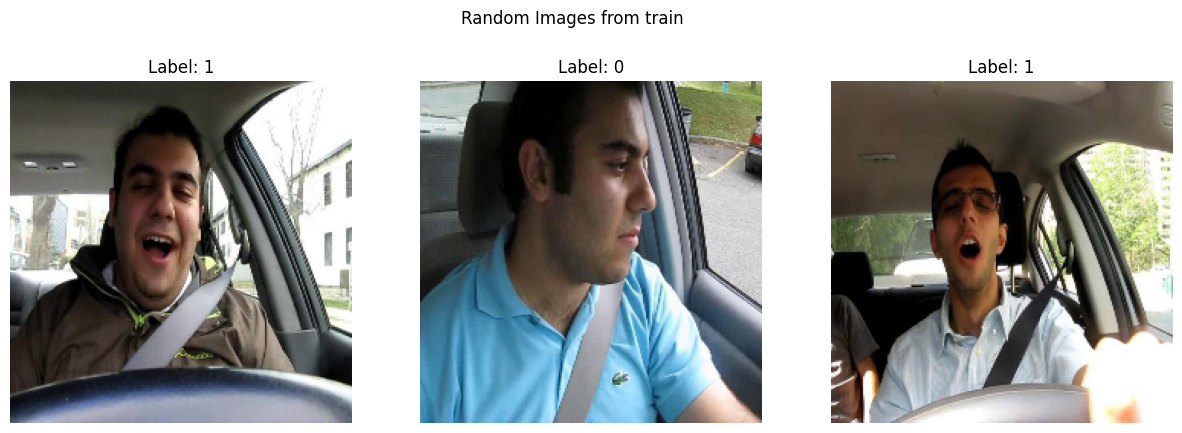

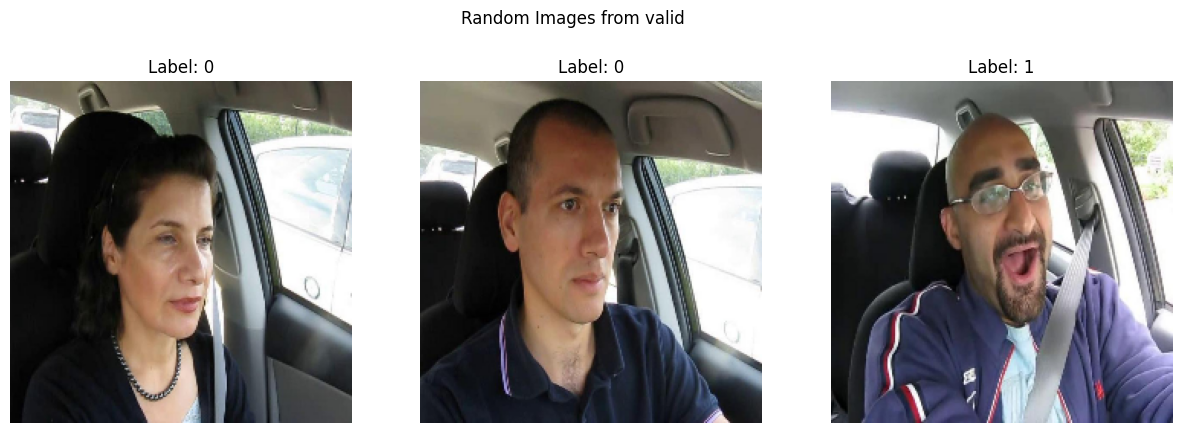

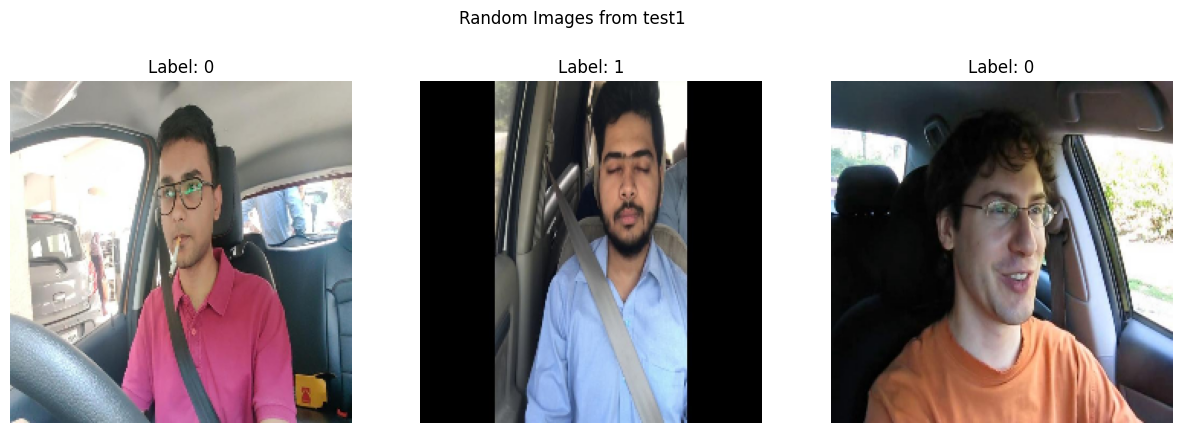

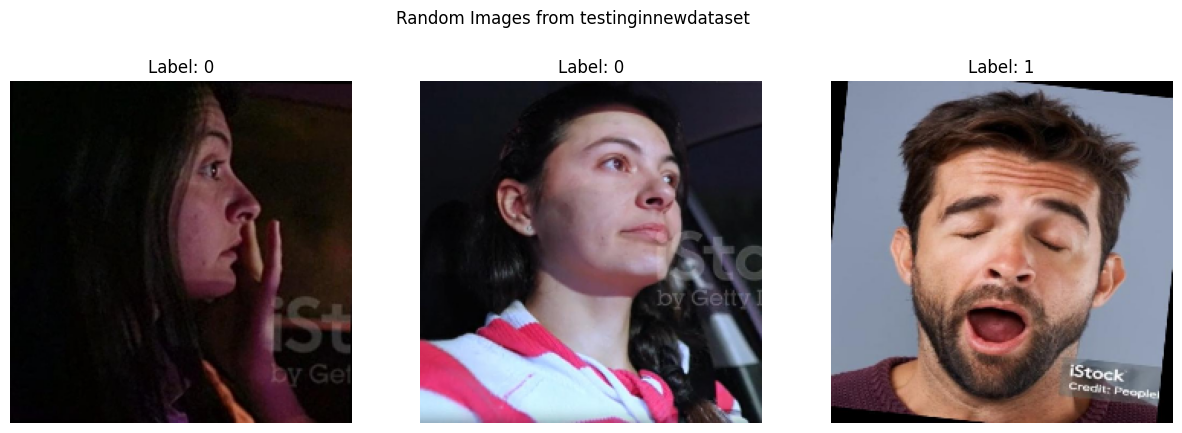

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import random
import pandas as pd

def display_random_images(data_dir, csv_file, img_size, num_images=3):
    df = pd.read_csv(csv_file)
    img_path_column = 'filename'
    label_column = ' drowsy'
    random_images = df.sample(num_images)
    plt.figure(figsize=(15, 5))
    for i, (_, row) in enumerate(random_images.iterrows()):
        img_path = os.path.join(data_dir, row[img_path_column])
        label = row[label_column]
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(cv2.resize(img, img_size), cv2.COLOR_BGR2RGB)
            plt.subplot(1, num_images, i + 1)
            plt.imshow(img)
            plt.title(f"Label: {label}")
            plt.axis('off')
    plt.suptitle(f"Random Images from {data_dir}")
    plt.show()

img_size = (224, 224)


display_random_images('train', 'Patient-Specific_Training_of_Deep_Learning_Models_for_Drowsiness_Detection/Datasets/DD1_Dataset/train/_classes.csv', img_size)
display_random_images('valid', 'Patient-Specific_Training_of_Deep_Learning_Models_for_Drowsiness_Detection/Datasets/DD1_Dataset/valid/_classes.csv', img_size)
display_random_images('test1', 'Patient-Specific_Training_of_Deep_Learning_Models_for_Drowsiness_Detection/Datasets/DD1_Dataset/test1/_classes.csv', img_size)
display_random_images('testinginnewdataset', 'Patient-Specific_Training_of_Deep_Learning_Models_for_Drowsiness_Detection/Datasets/DD1_Dataset/testinginnewdataset/_classes.csv', img_size)


### MobileNetV3Small

In [27]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2


base_model = MobileNetV3Small(input_shape=(224, 224, 3), include_top=False, weights='imagenet')


for layer in base_model.layers[:60]:  
    layer.trainable = False


inputs = Input(shape=(224, 224, 3), name='image_input')
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)  


mobilenet_model = Model(inputs, output)


mobilenet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

from tensorflow.keras.utils import to_categorical


train_labels = train_labels.astype('int')
val_labels = val_labels.astype('int')


early_stopping = EarlyStopping(patience=3, restore_best_weights=True)


history = mobilenet_model.fit(
    train_data, train_labels,
    validation_data=(val_data, val_labels),
    epochs=15,
    batch_size=32,
    callbacks=[early_stopping]
)


Epoch 1/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 77s 582ms/step - accuracy: 0.6603 - loss: 2.0898 - val_accuracy: 0.5000 - val_loss: 1.1538
Epoch 2/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 48s 494ms/step - accuracy: 0.8436 - loss: 0.7089 - val_accuracy: 0.5000 - val_loss: 0.8855
Epoch 3/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 56s 583ms/step - accuracy: 0.9244 - loss: 0.3260 - val_accuracy: 0.4593 - val_loss: 0.7522
Epoch 4/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 48s 504ms/step - accuracy: 0.9646 - loss: 0.1667 - val_accuracy: 0.5000 - val_loss: 0.7297
Epoch 5/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 48s 505ms/step - accuracy: 0.9745 - loss: 0.1033 - val_accuracy: 0.5366 - val_loss: 0.7049
Epoch 6/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 47s 485ms/step - accuracy: 0.9856 - loss: 0.0568 - val_accuracy: 0.5366 - val_loss: 0.6926
Epoch 7/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 49s 512ms/step - accuracy: 0.9871 - loss: 0.0422 - val_accuracy: 0.5000 - val_loss: 0.7156
Epoch 8/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 53s 555ms/step - accuracy: 0.9932 - loss: 0.0298 - val_accu

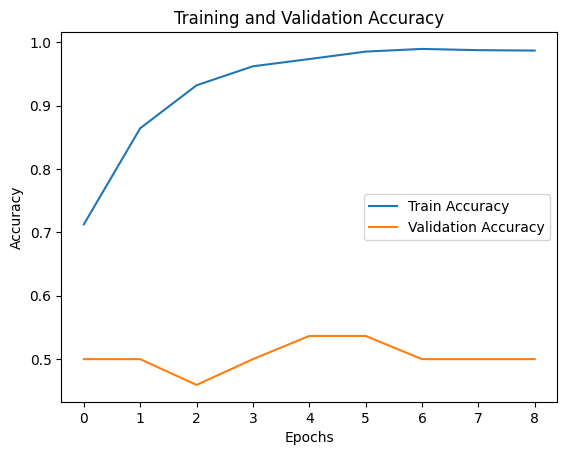

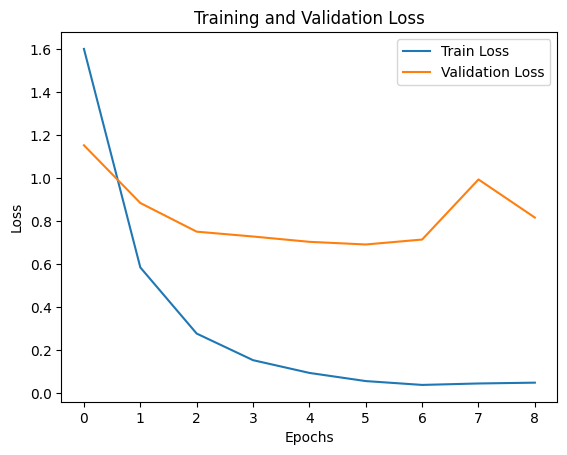

In [28]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


Evaluation on Test Set 1:
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 374ms/step
Test Set 1 - Accuracy: 0.4524

Test Set 1 - Confusion Matrix:


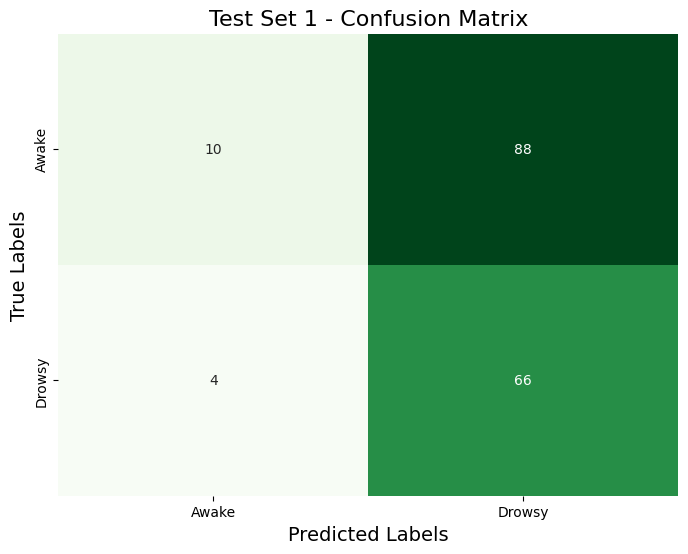

Test Set 1 - Classification Report:
              precision    recall  f1-score   support

       Awake       0.71      0.10      0.18        98
      Drowsy       0.43      0.94      0.59        70

    accuracy                           0.45       168
   macro avg       0.57      0.52      0.38       168
weighted avg       0.60      0.45      0.35       168


Evaluation on Test Set 2:
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step
Test Set 2 - Accuracy: 0.4866

Test Set 2 - Confusion Matrix:


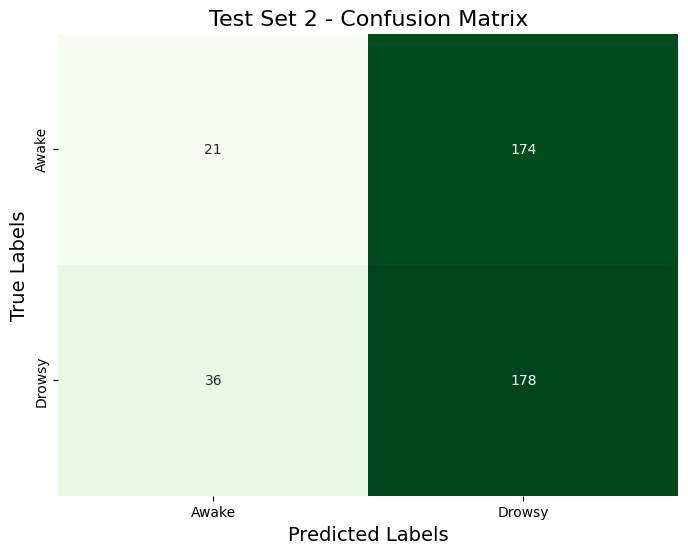

Test Set 2 - Classification Report:
              precision    recall  f1-score   support

       Awake       0.37      0.11      0.17       195
      Drowsy       0.51      0.83      0.63       214

    accuracy                           0.49       409
   macro avg       0.44      0.47      0.40       409
weighted avg       0.44      0.49      0.41       409



In [29]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    """
    Plot a confusion matrix as a heatmap using seaborn.

    Args:
        y_true (list or np.array): True labels.
        y_pred (list or np.array): Predicted labels.
        class_names (list): List of class names corresponding to labels.
        title (str): Title of the confusion matrix plot.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Greens",  # Green colormap
        xticklabels=class_names,
        yticklabels=class_names,
        cbar=False
    )
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("True Labels", fontsize=14)
    plt.title(title, fontsize=16)
    plt.show()


def evaluate_model(model, data, labels, class_names, dataset_name):
    """
    Evaluate a model on a given dataset, generate confusion matrix visualization,
    and print classification report.

    Args:
        model: Trained Keras model.
        data: Test data (images or embeddings).
        labels: True labels for the test data.
        class_names: List of class names for the labels.
        dataset_name: Name of the dataset being evaluated.
    """
    
    y_pred = (model.predict(data) > 0.5).astype(int)

    
    accuracy = accuracy_score(labels, y_pred)
    print(f"{dataset_name} - Accuracy: {accuracy:.4f}\n")

    
    print(f"{dataset_name} - Confusion Matrix:")
    plot_confusion_matrix(labels, y_pred, class_names, title=f"{dataset_name} - Confusion Matrix")

    
    print(f"{dataset_name} - Classification Report:")
    report = classification_report(labels, y_pred, target_names=class_names, zero_division=0)
    print(report)



print("Evaluation on Test Set 1:")
evaluate_model(mobilenet_model, test_data, test_labels, class_names=['Awake', 'Drowsy'], dataset_name="Test Set 1")


print("\nEvaluation on Test Set 2:")
evaluate_model(mobilenet_model, new_test_data, new_test_labels, class_names=['Awake', 'Drowsy'], dataset_name="Test Set 2")


In [30]:

mobilenet_model.save("mobilenetBaseline.keras")
print("Model saved as 'mobilenetBaseline.keras'")


Model saved as 'mobilenetBaseline.keras'


### EfficientNetV2B0

In [7]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


base_model = EfficientNetV2B0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')


for layer in base_model.layers[:200]:  
    layer.trainable = False


inputs = Input(shape=(224, 224, 3), name='image_input')
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)  


efficientnet = Model(inputs, output)


efficientnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(patience=3, restore_best_weights=True)


history = efficientnet.fit(
    train_data,  
    train_labels,
    validation_data=(val_data, val_labels),
    epochs=15,
    callbacks=[early_stopping],
    batch_size=32
)



Epoch 1/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.5017 - loss: 2.2037 - val_accuracy: 0.5000 - val_loss: 0.9252
Epoch 2/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.4970 - loss: 0.8484 - val_accuracy: 0.5976 - val_loss: 0.7194
Epoch 3/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.5153 - loss: 0.7225 - val_accuracy: 0.4959 - val_loss: 0.7067
Epoch 4/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.5264 - loss: 0.7199 - val_accuracy: 0.5081 - val_loss: 0.7070
Epoch 5/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.5217 - loss: 0.7133 - val_accuracy: 0.6138 - val_loss: 0.7005
Epoch 6/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.5264 - loss: 0.7020 - val_accuracy: 0.5650 - val_loss: 0.6952
Epoch 7/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.5615 - loss: 0.6889 - val_accuracy: 0.5000 - val_loss: 0.7007
Epoch 8/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.5689 - loss: 0.6828 - val_accuracy: 0.5244 - v

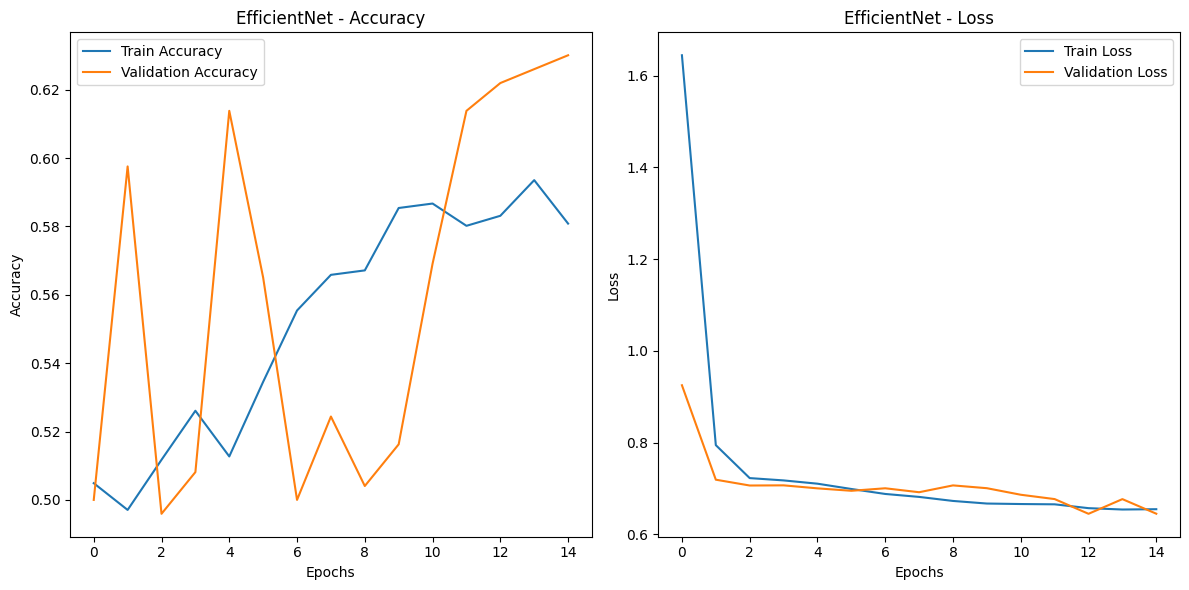

In [9]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('EfficientNet - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('EfficientNet - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Evaluation on Test Set 1:
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
Test Set 1 - Accuracy: 0.6786

Test Set 1 - Confusion Matrix:


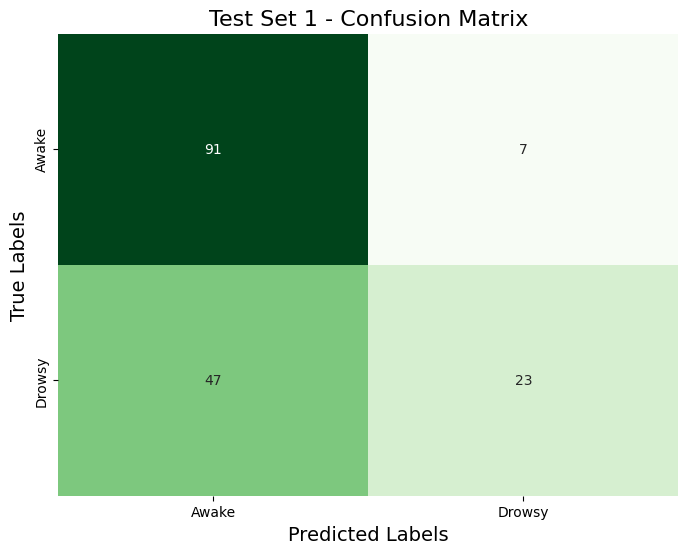

Test Set 1 - Classification Report:
              precision    recall  f1-score   support

       Awake       0.66      0.93      0.77        98
      Drowsy       0.77      0.33      0.46        70

    accuracy                           0.68       168
   macro avg       0.71      0.63      0.62       168
weighted avg       0.70      0.68      0.64       168


Evaluation on Test Set 2:
13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step
Test Set 2 - Accuracy: 0.4548

Test Set 2 - Confusion Matrix:


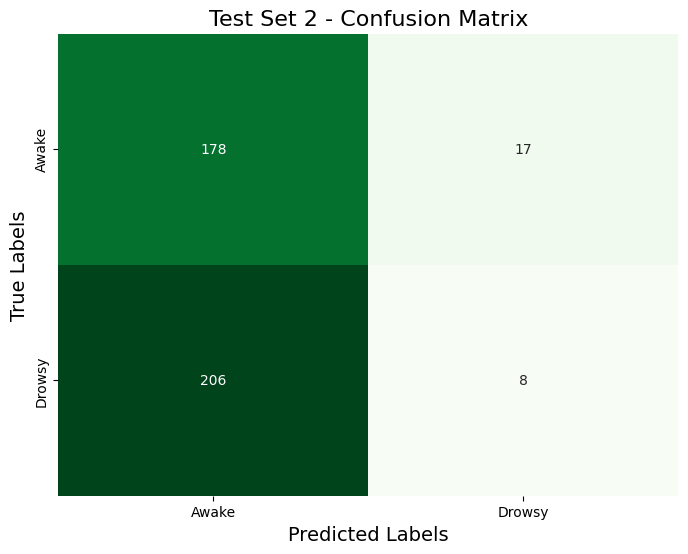

Test Set 2 - Classification Report:
              precision    recall  f1-score   support

       Awake       0.46      0.91      0.61       195
      Drowsy       0.32      0.04      0.07       214

    accuracy                           0.45       409
   macro avg       0.39      0.48      0.34       409
weighted avg       0.39      0.45      0.33       409



In [49]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Greens",
        xticklabels=class_names,
        yticklabels=class_names,
        cbar=False
    )
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("True Labels", fontsize=14)
    plt.title(title, fontsize=16)
    plt.show()

def evaluate_model(model, data, labels, class_names, dataset_name):
    y_pred = (model.predict(data) > 0.5).astype(int)
    accuracy = accuracy_score(labels, y_pred)
    print(f"{dataset_name} - Accuracy: {accuracy:.4f}\n")
    print(f"{dataset_name} - Confusion Matrix:")
    plot_confusion_matrix(labels, y_pred, class_names, title=f"{dataset_name} - Confusion Matrix")
    print(f"{dataset_name} - Classification Report:")
    report = classification_report(labels, y_pred, target_names=class_names, zero_division=0)
    print(report)

print("Evaluation on Test Set 1:")
evaluate_model(efficientnet, test_data, test_labels, class_names=['Awake', 'Drowsy'], dataset_name="Test Set 1")

print("\nEvaluation on Test Set 2:")
evaluate_model(efficientnet, new_test_data, new_test_labels, class_names=['Awake', 'Drowsy'], dataset_name="Test Set 2")


In [12]:

efficientnet.save("efficientBaseline.keras")
print("Model saved as 'efficientBaseline.keras'")


Model saved as 'efficientBaseline.keras'


### ResNet50

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50


base_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')  


for layer in base_model.layers[:140]:  
    layer.trainable = False


input_layer = Input(shape=(224, 224, 3), name='input')  
x = base_model(input_layer)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)  
output = Dense(1, activation='sigmoid')(x)  


resnet = Model(inputs=input_layer, outputs=output)


resnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(patience=5, restore_best_weights=True)


historyResnet = resnet.fit(
    train_data, train_labels,
    validation_data=(val_data, val_labels),
    epochs=15,
    callbacks=[early_stopping],
    batch_size=32
)



Epoch 1/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 412s 4s/step - accuracy: 0.6279 - loss: 2.0990 - val_accuracy: 0.5041 - val_loss: 3.2364
Epoch 2/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 355s 4s/step - accuracy: 0.6691 - loss: 0.7331 - val_accuracy: 0.6707 - val_loss: 1.8587
Epoch 3/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 305s 3s/step - accuracy: 0.6997 - loss: 0.5858 - val_accuracy: 0.7317 - val_loss: 1.7754
Epoch 4/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 282s 3s/step - accuracy: 0.7292 - loss: 0.5430 - val_accuracy: 0.5000 - val_loss: 45.4114
Epoch 5/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 311s 3s/step - accuracy: 0.7523 - loss: 0.5016 - val_accuracy: 0.5041 - val_loss: 1.6171
Epoch 6/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 290s 3s/step - accuracy: 0.7550 - loss: 0.4888 - val_accuracy: 0.7317 - val_loss: 0.6096
Epoch 7/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 291s 3s/step - accuracy: 0.7897 - loss: 0.4381 - val_accuracy: 0.5000 - val_loss: 3.5879
Epoch 8/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 287s 3s/step - accuracy: 0.8173 - loss: 0.4110 - val_accuracy: 0.5203 - 

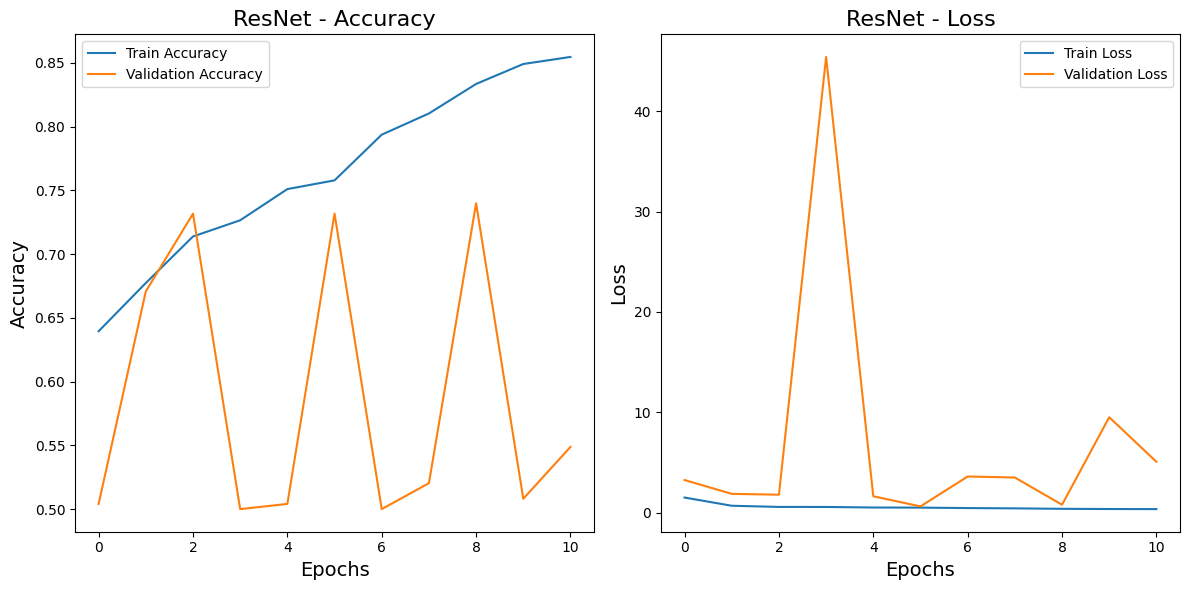

In [14]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(historyResnet.history['accuracy'], label='Train Accuracy')
plt.plot(historyResnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet - Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(historyResnet.history['loss'], label='Train Loss')
plt.plot(historyResnet.history['val_loss'], label='Validation Loss')
plt.title('ResNet - Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()


In [52]:

final_training_accuracy = historyResnet.history['accuracy'][-1]
final_validation_accuracy = historyResnet.history['val_accuracy'][-1]
final_training_loss = historyResnet.history['loss'][-1]
final_validation_loss = historyResnet.history['val_loss'][-1]


print("Final Training Accuracy: {:.4f}".format(final_training_accuracy))
print("Final Validation Accuracy: {:.4f}".format(final_validation_accuracy))
print("Final Training Loss: {:.4f}".format(final_training_loss))
print("Final Validation Loss: {:.4f}".format(final_validation_loss))


Final Training Accuracy: 0.8546
Final Validation Accuracy: 0.5488
Final Training Loss: 0.3379
Final Validation Loss: 5.0568


Evaluation on Test Set 1:
6/6 ━━━━━━━━━━━━━━━━━━━━ 46s 6s/step
Test Set 1 - Accuracy: 0.6845

Test Set 1 - Confusion Matrix:


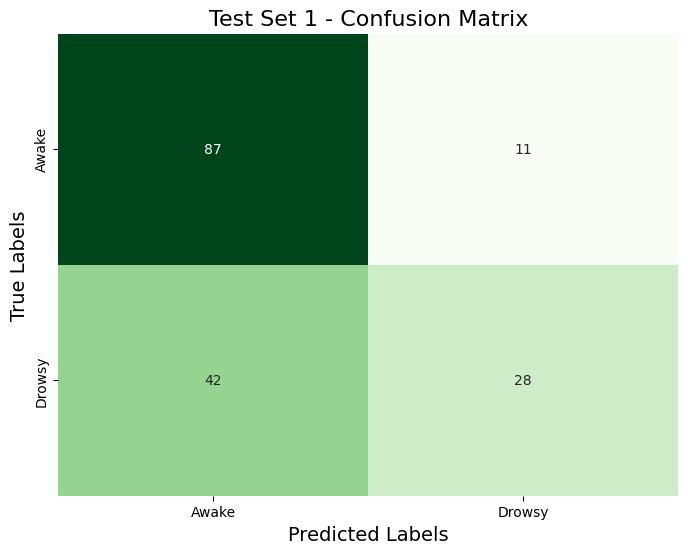

Test Set 1 - Classification Report:
              precision    recall  f1-score   support

       Awake       0.67      0.89      0.77        98
      Drowsy       0.72      0.40      0.51        70

    accuracy                           0.68       168
   macro avg       0.70      0.64      0.64       168
weighted avg       0.69      0.68      0.66       168


Evaluation on Test Set 2:
13/13 ━━━━━━━━━━━━━━━━━━━━ 88s 7s/step
Test Set 2 - Accuracy: 0.5159

Test Set 2 - Confusion Matrix:


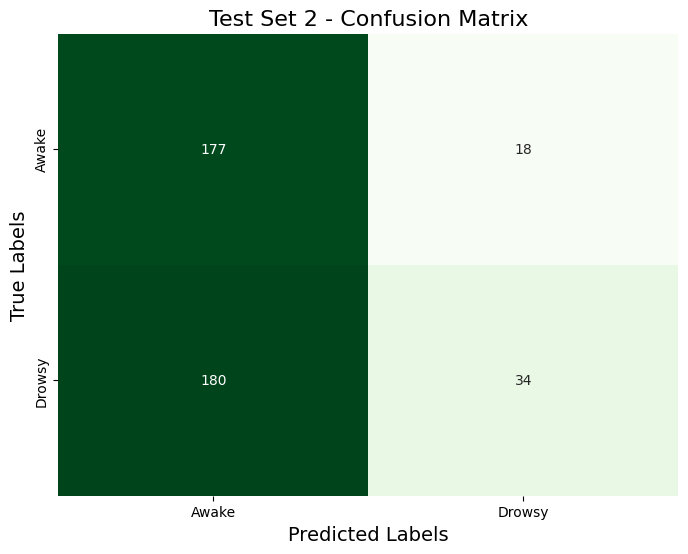

Test Set 2 - Classification Report:
              precision    recall  f1-score   support

       Awake       0.50      0.91      0.64       195
      Drowsy       0.65      0.16      0.26       214

    accuracy                           0.52       409
   macro avg       0.57      0.53      0.45       409
weighted avg       0.58      0.52      0.44       409



In [50]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Greens",
        xticklabels=class_names,
        yticklabels=class_names,
        cbar=False
    )
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("True Labels", fontsize=14)
    plt.title(title, fontsize=16)
    plt.show()

def evaluate_model(model, data, labels, class_names, dataset_name):
    y_pred = (model.predict(data) > 0.5).astype(int)
    accuracy = accuracy_score(labels, y_pred)
    print(f"{dataset_name} - Accuracy: {accuracy:.4f}\n")
    print(f"{dataset_name} - Confusion Matrix:")
    plot_confusion_matrix(labels, y_pred, class_names, title=f"{dataset_name} - Confusion Matrix")
    print(f"{dataset_name} - Classification Report:")
    report = classification_report(labels, y_pred, target_names=class_names, zero_division=0)
    print(report)

print("Evaluation on Test Set 1:")
evaluate_model(resnet, test_data, test_labels, class_names=['Awake', 'Drowsy'], dataset_name="Test Set 1")

print("\nEvaluation on Test Set 2:")
evaluate_model(resnet, new_test_data, new_test_labels, class_names=['Awake', 'Drowsy'], dataset_name="Test Set 2")


In [16]:

resnet.save("ResNetBaseline.keras")
print("ResNet model saved as 'ResNetBaseline.keras'")


ResNet model saved as 'ResNetBaseline.keras'


In [51]:
print("Unique labels in test_labels:", np.unique(test_labels))


Unique labels in test_labels: [0 1]
